In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt


2024-11-04 09:53:55.917937: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 09:53:55.925186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 09:53:55.933585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 09:53:55.936207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 09:53:55.942867: I tensorflow/core/platform/cpu_feature_guar

#### [This notebook follows  main implemetations of Physics-based Deep Learning Book (v0.2)](https://physicsbaseddeeplearning.org/bayesian-code.html)
#### [Also see the complete code on GitHub](https://github.com/thunil/Deep-Flow-Prediction/tree/master)


# <span style="color:blue">1.Load directory</span>

In [2]:
# Files path
directory= os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES")

# Add directory to sys.path
sys.path.append(directory)

# import script
import param  

# Set the number of cores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
num_threads = param.n_threads  
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)



#### Define parameters

In [3]:
#Load the main directory
paths=param.list_paths 
for i,j in enumerate(paths):
    print(f'{i} => {j}')

# Defining amount of train,valid,test images
n_train=0.8;    n_valid=0.1;    n_test=0.1

# Defining a sample i.e.
n_sample=500                    

#Pack them into batches (we’ll use batches of 10 images e.g.)
BATCH_SIZE=10                        

# For resizing dimentions
h=128
w=256

0 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry
1 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude
2 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Pression
3 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U001
4 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U002


# <span style="color:blue">2. Preprocessing </span>

In [63]:
# method for reading image    
def get_img(img_name):
    return ski.io.imread(img_name)
 
# method for turning to a grey or binary image 
def processing(image,option=True):
        x = get_img(image)  
        x = rgb2gray(x)       # It returns a grayscale image with floating point values in the range from 0 to 1
        x =cv.resize(x,(w,h)) # Reshape image 
    
        # Binary option otherwise gray
        if (option):
            x=ski.util.img_as_ubyte(x)  # Convert it back to the original data type and the data range back 0 to 255. 
                                        # It is often better to use image values represented by floating point values 
            best_value_threshold=np.round(filters.threshold_otsu(x)) #  Otsu’s method calculates an “optimal” threshold
            _,x= cv.threshold(x, best_value_threshold, 255, cv.THRESH_BINARY_INV)

        x=x[:, :, np.newaxis]
        return x
    
# method for splitting data
def split_data(path,n_sample,n_train,n_valid,n_test):
        
        files=sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".png")])
        n_files=len(files)
        
        if(n_files>n_sample):
                print()
                print(' ######  \t Loaded ',n_sample,' of ',n_files,'from ',path,'\t #####\n')
                if (n_train + n_valid + n_test == 1.0):
        
                    n_train= math.floor(n_sample*n_train)
                    n_valid = math.floor(n_sample*n_valid) + n_train
                    n_test = math.floor(n_sample*n_test) + n_valid
              
                    (files_train,files_valid,files_tests) = (files[0:n_train], files[n_train:n_valid],files[n_valid:n_test])
                    
                return files_train,files_valid,files_tests

def arrays_img_processed(data,type=True): # True for Geometry 
    # begin in data[1:] 
    if type:
        list_arrays=[processing(image,option=True).astype(np.float32) for image in data[1:] ]
    else:
        list_arrays=[processing(image,option=False).astype(np.float32) for image in data[1:] ]
   
    return np.array(list_arrays) 


In [64]:
# Geometry
geo_train,geo_valid,geo_tests=split_data(paths[0],n_sample,n_train,n_valid,n_test)
geo_array_train=arrays_img_processed(geo_train)
geo_array_valid=arrays_img_processed(geo_valid)
geo_array_tests=arrays_img_processed(geo_tests)

# Magnitude
specific_tarjet=paths[1]

mag_train,mag_valid,mag_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)
mag_array_train=arrays_img_processed(mag_train,False)
mag_array_valid=arrays_img_processed(mag_valid,False)
mag_array_tests=arrays_img_processed(mag_tests,False)

print(f'Training data for geometry: {geo_array_train.shape}')
print(f'Training data for magnitude: {mag_array_train.shape}')
print()
print(f'Valid data for geometry: {geo_array_valid.shape}')
print(f'Valid data for magnitude: {mag_array_valid.shape}')
print()
print(f'Test data for geometry: {geo_array_tests.shape}')
print(f'Test data for magnitude: {mag_array_tests.shape}')



 ######  	 Loaded  500  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry 	 #####


 ######  	 Loaded  500  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude 	 #####

Training data for geometry: (399, 128, 256, 1)
Training data for magnitude: (399, 128, 256, 1)

Valid data for geometry: (49, 128, 256, 1)
Valid data for magnitude: (49, 128, 256, 1)

Test data for geometry: (49, 128, 256, 1)
Test data for magnitude: (49, 128, 256, 1)


### <span style="color:red">2.1 TensorFlow Dataset objects</span>
A Dataset object is an iterator. It will typically return batches of input data and tarjet

In [7]:
# slices of an array in the form of objects by using tf.data.Dataset.from_tensor_slices() method
train_data=tf.data.Dataset.from_tensor_slices((geo_array_train, mag_array_train))
valid_data=tf.data.Dataset.from_tensor_slices((geo_array_valid, mag_array_valid))

#representing the number of consecutive elements of this dataset to combine in a single batch
#the last batch is dropped in the case it has fewer than batch_size elements

trainLoader = train_data.batch(BATCH_SIZE,drop_remainder=True)
valiLoader = valid_data.batch(BATCH_SIZE,drop_remainder=True)

print("Training & validation batches number: {} , {}\n".format(len(trainLoader),len(valiLoader) ))
i=0;
for geo_batch, mag_batch in trainLoader:
    print("geo batch shape:", geo_batch.shape)
    print("mag batch shape:", mag_batch.shape)
    i=i+1
    print(f'batch number {i}')
    print('------------------')
    break



Training & validation batches number: 39 , 4

geo batch shape: (10, 128, 256, 1)
mag batch shape: (10, 128, 256, 1)
batch number 1
------------------


I0000 00:00:1730732122.095743   10732 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-04 09:55:22.114213: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# <span style="color:blue">3. Plot </span>
#### <span style="color:blue">Look at Data </span>

In [8]:
def plot(a1,a2,title=None,opt=None):
    if opt==None:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Input',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('Geometry',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Target output',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)
    else:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Real',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('u',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Prediction',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)
        
            

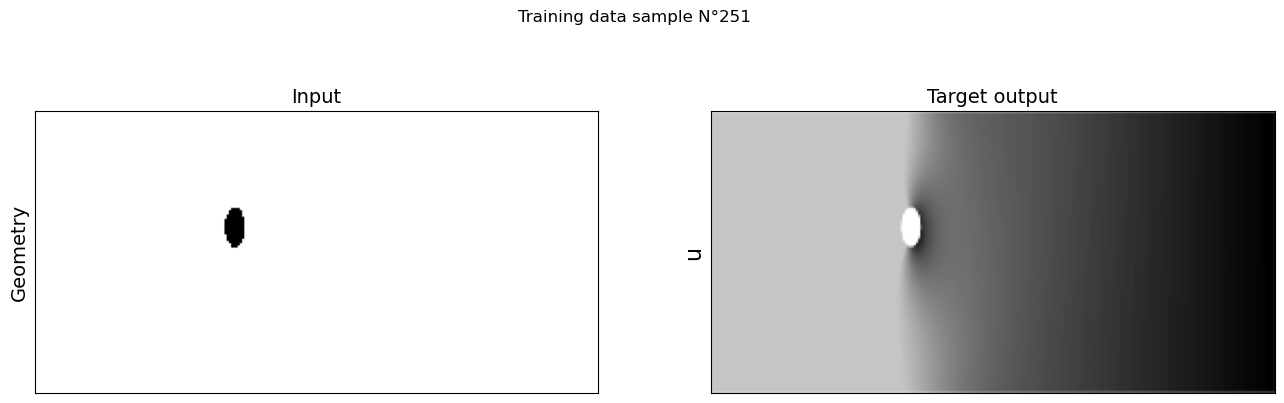

In [9]:
NUM=random.sample(range(1, geo_array_train.shape[0]), 1)
plot( geo_array_train[NUM[0]],mag_array_train[NUM[0]], title=f"Training data sample N°{NUM[0]}") 

# <span style="color:blue">4. Architecture </span>

In [10]:
class U_net(tf.keras.Model):
    
        def __init__(self, num_classes):
            super(U_net,self).__init__()
            
            self.block_1=self.encoder(64)
            self.pool_1=MaxPooling2D((2, 2))

            self.block_2=self.encoder(128)
            self.pool_2=MaxPooling2D((2, 2))

            self.block_3=self.encoder(256)
            self.pool_3=MaxPooling2D((2, 2))

            self.block_4=self.encoder(512)
            self.pool_4=MaxPooling2D((2, 2))

            self.bottleneck_1=Conv2D(1024, (3,3), activation='relu', padding='same')
            self.bottleneck_2=Conv2D(1024, (3,3), activation='relu', padding='same')

            self.up_block_1=self.decoder(512)
            self.up_block_2=self.decoder(256)
            self.up_block_3=self.decoder(128)
            self.up_block_4=self.decoder(64)

            self.output_model=Conv2D(num_classes, (1, 1), activation="relu", padding="same")


        def encoder(self,num_filters):
            
            block = tf.keras.Sequential(name='Encoder_part')
            block.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
            block.add(BatchNormalization())
            block.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
            block.add(BatchNormalization())

            return block

        def decoder(self,num_filters):
            
             block = tf.keras.Sequential(name='decoder_part')
             block.add(Conv2DTranspose(num_filters,(2,2),strides=(2, 2),padding="same"))
             block.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
             block.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same'))

             return block
            
        # Forward pass 
        def call(self,inputs,training=False):
            #inputs=Input((h, w,1))
            
            #Encoder
            x1=self.block_1(inputs)
            p1=self.pool_1(x1)

            x2=self.block_2(p1)
            p2=self.pool_2(x2)
            
            x3=self.block_3(p2)
            p3=self.pool_3(x3)
            
            x4=self.block_4(p3)
            p4=self.pool_4(x4)

            b1= self.bottleneck_1(p4)
            b2= self.bottleneck_2(b1)

            # Decoder
            u1 = self.up_block_1(b2)
            u2 = concatenate([u1, x4])

            u3 = self.up_block_2(u2)
            u4 = concatenate([u3, x3])

            u5 = self.up_block_3(u4)
            u6 = concatenate([u5, x2])

            u7 = self.up_block_4(u6)
            u8 = concatenate([u7, x1])

            outputs = self.output_model(u8)
            return outputs
        
  

# <span style="color:blue">5. Setup</span>

### <span style="color:red">5.1 Hiperparameters</span>

In [33]:
BATCH_SIZE=50
LR=0.01            
EPOCHS =150                       
DECAY_RATE=0.015
num_train_data=geo_array_train.shape[0]
NUM_CLASESS=1 # Only magnitude e.g.
   

### <span style="color:red">5.2 Learning rate</span>

Exponential Decay: 

$$ lr=lr_{ initial } \times e ^{-\text{decate rate} \times \text{epoch}} $$

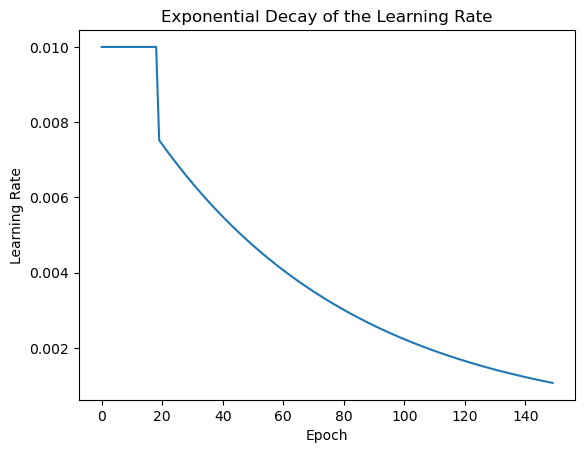

In [35]:
def exponential_decay(epoch,epochs,lr_ini=LR,decay_rate=DECAY_RATE):
    if epoch < epochs*0.125:
        return lr_ini
    else:
        return  lr_ini * np.exp(-decay_rate*epoch)
    
epochs = np.arange(EPOCHS)
learning_rates = [exponential_decay(epoch,EPOCHS) for epoch in epochs]

plt.plot(epochs, learning_rates, label="Learning Rate")
plt.title("Exponential Decay of the Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(False)
plt.show()    

### <span style="color:red">5.3 Losses function</span>
The loss function to train the neural networks, and a reasonable reduction of the loss during the optimization was only possible when adding either the MSE or the MAE which combines with the mean relative error.

Definition of custom loss function MSE+

$$ MSE+ = \frac{1}{|D|} \sum_{P \in D} \frac{1}{|I_P|} \sum_{p \in I_P} ( \left\|u_p - \hat{u}_p \right\|_2^2 + \frac{\left\|u_p - \hat{u}_p \right\|_2}{ \left\|u_p \right\|_2 + 10^{-4}}) $$

Definition of custom loss function MAE+

$$MAE+ = \frac{1}{|D|} \sum_{P \in D} \frac{1}{|I_P|} \sum_{p \in I_P} (\left\|u_p - \hat{u}_p \right\|_1 + \frac{ \left\| u_p - \hat{u}_p  \right\|_2 }{\left\| u_p  \right\|_2 + 10^{-4}})$$

$u_p$ es el vector de predicción de velocidad en el píxel $p$.

$\hat{u}_p$ es la velocidad de referencia en $p$.

$D$ es el conjunto de todos los obstáculos $P$ considerados.

$I_P$ es el conjunto de todos los píxeles $p$ que no están cubiertos por el obstáculo respectivo.


#### [See paper](https://etna.math.kent.edu/vol.56.2022/pp235-255.dir/pp235-255.pdf) 

![Ilustration](MASK.png)


<strong>Implementing a custom metric by subclassing the Metric class To be implemented by subclasses</strong>

<strong>__ init __():</strong> All state variables should be created in this method by calling self.add_variable() like:  
self.var = self.add_variable(...)

<strong>update_state():</strong> Has all updates to the state variables like: self.var.assign(...).

<strong>result():</strong> Computes and returns a scalar value or a dict of scalar values for the metric from the state variables.

#### [See tf.keras.Metric](https://www.tensorflow.org/api_docs/python/tf/keras/Metric) 

In [36]:
class MAEplus(tf.keras.metrics.Metric):
    
    def __init__(self, name="MaePlus", **kwargs):
        super().__init__(name=name, **kwargs)
        
        self.mae_sum = self.add_weight(name="mae_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros",dtype="int32")
        
    def update_state(self, u_true, u_pred, sample_weight=None):
        
          # Regularizar  
          Eps=1e-4
        
          #get the dimensions of u_true
          tensor_shape= tf.shape(u_true)
        
          # create ones tensor under the given dimensions
          mask= tf.ones(tensor_shape, dtype=u_true.dtype)

          # get indices of u_true where pixels are of value 1
          index = tf.where(u_true == 1)
          scalar_value = 0
          values = tf.fill([tf.shape(index)[0]], scalar_value)
          values = tf.cast(values, mask.dtype)
        
          # Updating the ones and zeros mask: Zero pixels inside the obstacle
          mask=tf.tensor_scatter_nd_update(mask, index, values)

          # Application of the mask to real and predicted data
          u_true_masked = tf.multiply(u_true, mask) 
          u_pred_masked = tf.multiply(u_pred, mask)

          # Selects only the elements at positions where mask is True i.e 1.
          Ip=tf.boolean_mask(u_pred, mask)
          shape_tensor=tf.shape(Ip)
        
          # count the pixels that are not covered by the obstacle 
          Ip_value = tf.get_static_value(shape_tensor)[0] 

          E_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_true_masked - u_pred_masked)))  
          E_normL1 = tf.reduce_sum(tf.abs(u_true_masked  - u_pred_masked))
          u_pred_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_pred_masked)))

          # Formula
          mae_loss=tf.reduce_sum(E_normL1 + E_normL2/(u_pred_normL2 + Eps))
          mae_loss=mae_loss/Ip_value
        
          self.mae_sum.assign_add(mae_loss)
          self.total_samples.assign_add(tf.cast(tf.size(u_true), tf.float32))

    def result(self):
        return self.mae_sum / tf.cast(self.total_samples, tf.float32)

    def reset_states(self):
        self.mae_sum.assign(0.0)
        self.total_samples.assign(0)


In [37]:
# Same ideas as before
def MSEplus(u_true, u_pred):
  
  Eps=1e-4
  tensor_shape= tf.shape(u_true)
  mask= tf.ones(tensor_shape, dtype=u_true.dtype)
  index = tf.where(u_true == 1)
  scalar_value = 0
  values = tf.fill([tf.shape(index)[0]], scalar_value)
  values = tf.cast(values, mask.dtype)
  mask=tf.tensor_scatter_nd_update(mask, index, values)

  u_true_masked = tf.multiply(u_true, mask) 
  u_pred_masked = tf.multiply(u_pred, mask)
 
  Ip=tf.boolean_mask(u_pred, mask)
  shape_tensor=tf.shape(Ip)
  Ip_value = tf.get_static_value(shape_tensor)[0] 
    
  E_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_true_masked - u_pred_masked)))
  E=tf.reduce_sum(tf.square(u_true_masked - u_pred_masked))
  u_pred_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_pred_masked)))
  mse_loss = tf.reduce_sum(E + E_normL2 / (u_pred_normL2 + Eps))
  mse_loss=mse_loss/Ip_value
  return mse_loss 

Definition of custom loss function classic MAE

$$MAE = \frac{1}{|D|} \sum_{P \in D} \frac{1}{|I_P|} \sum_{p \in I_P} (\left\|u_p - \hat{u}_p \right\|_1 )$$

$u_p$ es el vector de predicción de velocidad en el píxel $p$.

$\hat{u}_p$ es la velocidad de referencia en $p$.

$D$ es el conjunto de todos los obstáculos $P$ considerados.

$I_P$ es el conjunto de todos los píxeles $p$ que no están cubiertos por el obstáculo respectivo.


In [38]:
# No used 
class MAE(tf.keras.metrics.Metric):
    
    def __init__(self, name="MaePlus", **kwargs):
        super().__init__(name=name, **kwargs)
        
        self.mae_sum = self.add_weight(name="mae_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros",dtype="int32")
        
    def update_state(self, u_true, u_pred, sample_weight=None):
        
          # Regularizar  
          Eps=1e-4
        
          #get the dimensions of u_true
          tensor_shape= tf.shape(u_true)
        
          # create ones tensor under the given dimensions
          mask= tf.ones(tensor_shape, dtype=u_true.dtype)

          # get indices of u_true where pixels are of value 1
          index = tf.where(u_true == 1)
          scalar_value = 0
          values = tf.fill([tf.shape(index)[0]], scalar_value)
          values = tf.cast(values, mask.dtype)
        
          # Updating the ones and zeros mask: Zero pixels inside the obstacle
          mask=tf.tensor_scatter_nd_update(mask, index, values)

          # Application of the mask to real and predicted data
          u_true_masked = tf.multiply(u_true, mask) 
          u_pred_masked = tf.multiply(u_pred, mask)

          # Selects only the elements at positions where mask is True i.e 1.
          Ip=tf.boolean_mask(u_pred, mask)
          shape_tensor=tf.shape(Ip)
        
          # count the pixels that are not covered by the obstacle 
          Ip_value = tf.get_static_value(shape_tensor)[0] 

          
          E_normL1 = tf.reduce_sum(tf.abs(u_true_masked  - u_pred_masked))
          
          mae_loss=E_normL1/Ip_value
        
          self.mae_sum.assign_add(mae_loss)
          self.total_samples.assign_add(tf.cast(tf.size(u_true), tf.float32))

    def result(self):
        return self.mae_sum / tf.cast(self.total_samples, tf.float32)

    def reset_states(self):
        self.mae_sum.assign(0.0)
        self.total_samples.assign(0)


### <span style="color:red">5.4 Training</span>
#### [See instructive:  writing a training loop from tensorflow](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

In [39]:
'''
Gradient descent (with momentum) optimizer

momentum:
float hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations.
0 is vanilla gradient descent. Defaults to 0.0. 

Update rule for parameter w with gradient g when momentum is 0: w = w - learning_rate * g

Update rule when momentum is larger than 0: velocity = momentum * velocity - learning_rate * g,  w = w + velocity
'''

# Create an instance of the model
modelU = U_net(num_classes=NUM_CLASESS)

# Instantiate an optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9)
#optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# Prepare the metrics.
train_metric = MAEplus()
val_metric = MAEplus()
#train_metric = MAE()
#val_metric = MAE()
  

#### Training loop

In [40]:
mse_total_train=[]
mse_total_val=[]
mae_total_train=[]
mae_total_val=[]

for epoch in range(EPOCHS):
    
    # Call to exponential_decay function
    
    currLr = exponential_decay(epoch,EPOCHS)
    if currLr < LR:
       optimizer.learning_rate=currLr

    start_time = time.time()
    
    mse_loss_batch_train=0
    mae_loss_batch_train=0
    mse_loss_batch_val=0
    mae_loss_batch_val=0

    # **************  Run a training loop at the end of each epoch ******************
    for step, (inputs, targets) in enumerate(trainLoader):
        
        with tf.GradientTape(persistent=True) as tape:
            
            #Prediction for this minibatch
            u_prediction = modelU(inputs, training=True) 
            
            # Compute the loss value for MSE for this minibatch
            loss_value_mse = MSEplus(targets, u_prediction)   
            
        # backpropagate gradients and update parameters 
        gradients_mse=tape.gradient(loss_value_mse, modelU.trainable_weights)
        optimizer.apply_gradients(zip(gradients_mse, modelU.trainable_weights))
        #store losses per batch
        mse_loss_batch_train += loss_value_mse

        # Update training metric.
        train_metric.update_state(targets,u_prediction)

    # store losses per epoch
    mse_total_train+=[ mse_loss_batch_train/len(trainLoader)]
    
    #store metric per epoch
    train_result = train_metric.result()
    mae_total_train += [train_result]
    
    # Reset training metrics at the end of each epoch
    train_metric.reset_states()

    # ************  Run a validation loop at the end of each epoch ***************
    for input_val, target_val in valiLoader:
        
        u_prediction_val = modelU(input_val, training=False) 
        val_metric.update_state(target_val, u_prediction_val)
        loss_value_mse_val = MSEplus(target_val,u_prediction_val)   
        mse_loss_batch_val += loss_value_mse_val
        
    mse_total_val+=[mse_loss_batch_val/len(valiLoader)]
    val_result = val_metric.result()
    mae_total_val+= [val_result]
    val_metric.reset_states()

    if epoch<3 or epoch%5==0: 
        print('\nStart Epoch {}/{} ===>  Train_Loss_mse: {:.3f}, Valid_Loss_mse: {:.3f}, Train_metric_mae: {:.6f}, Valid_metric_mae: {:.6f}'.format(epoch, EPOCHS, mse_total_train[-1], mse_total_val[-1], mae_total_train[-1], mae_total_val[-1]))

print("====> Time taken: %.2fs" % (time.time() - start_time))

 

2024-11-04 10:07:05.144147: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-04 10:07:08.355700: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Start Epoch 0/150 ===>  Train_Loss_mse: 0.121, Valid_Loss_mse: 0.278, Train_metric_mae: 0.000001, Valid_metric_mae: 0.000001


2024-11-04 10:09:01.035482: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Start Epoch 1/150 ===>  Train_Loss_mse: 0.087, Valid_Loss_mse: 0.226, Train_metric_mae: 0.000001, Valid_metric_mae: 0.000001

Start Epoch 2/150 ===>  Train_Loss_mse: 0.083, Valid_Loss_mse: 0.167, Train_metric_mae: 0.000001, Valid_metric_mae: 0.000001


2024-11-04 10:12:50.697960: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Start Epoch 5/150 ===>  Train_Loss_mse: 0.044, Valid_Loss_mse: 0.236, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000001


2024-11-04 10:20:36.314672: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Start Epoch 10/150 ===>  Train_Loss_mse: 0.021, Valid_Loss_mse: 0.192, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000001


2024-11-04 10:35:54.492813: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Start Epoch 15/150 ===>  Train_Loss_mse: 0.019, Valid_Loss_mse: 0.190, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000001

Start Epoch 20/150 ===>  Train_Loss_mse: 0.019, Valid_Loss_mse: 0.021, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 25/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.021, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 30/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.020, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000


2024-11-04 11:06:58.482568: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Start Epoch 35/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.019, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 40/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.019, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 45/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.020, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 50/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.019, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 55/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.019, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 60/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.019, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000


2024-11-04 12:10:19.280737: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Start Epoch 65/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.019, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 70/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.019, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 75/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.019, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 80/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.018, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 85/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.018, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 90/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.018, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 95/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.018, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 100/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.018, Train_metric_mae: 0.000000, Valid_metr

2024-11-04 14:13:47.929613: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Start Epoch 130/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.018, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 135/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.018, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 140/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.018, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000

Start Epoch 145/150 ===>  Train_Loss_mse: 0.018, Valid_Loss_mse: 0.018, Train_metric_mae: 0.000000, Valid_metric_mae: 0.000000
====> Time taken: 112.99s


#### Number of trainable parameters

In [41]:
num_params = np.sum([np.prod(v.shape.as_list()) for v in modelU.trainable_variables])
print('The U-Net has {} parameters.'.format(num_params)) 
modelU.summary()

The U-Net has 28589185 parameters.


Model: "u_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_part (Sequential)       │ (10, 128, 256, 64)     │        38,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (10, 64, 128, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_part (Sequential)       │ (10, 64, 128, 128)     │       222,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (10, 32, 64, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_part (Sequential)       │ (10, 32, 64, 256)      │       887,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (10, 16, 32, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_part (Sequential)       │ (10, 16, 32, 512)      │     3,544,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (10, 8, 16, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (10, 8, 16, 1024)      │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (10, 8, 16, 1024)      │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_part (Sequential)       │ (10, 16, 32, 512)      │     6,817,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_part (Sequential)       │ (10, 32, 64, 256)      │     2,228,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_part (Sequential)       │ (10, 64, 128, 128)     │       557,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_part (Sequential)       │ (10, 128, 256, 64)     │       139,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (10, 128, 256, 1)      │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,593,025 (109.07 MB)

 Trainable params: 28,589,185 (109.06 MB)

 Non-trainable params: 3,840 (15.00 KB)

# <span style="color:blue">6. Visualizing results</span>

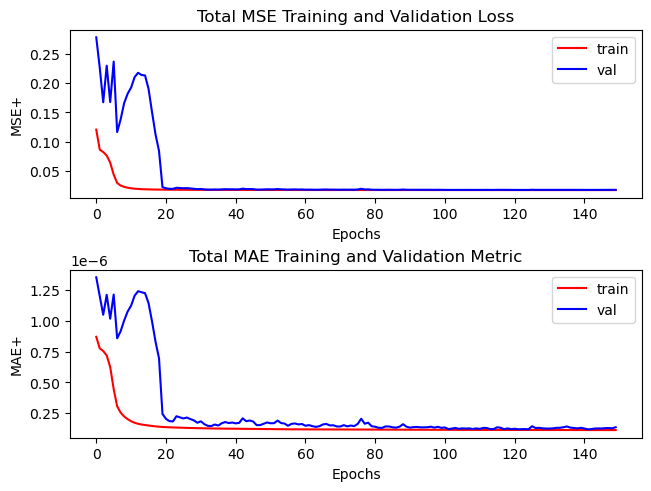

In [70]:
fig, axs = plt.subplots(2, 1,layout='constrained')
axs[0].plot(mse_total_train,color='red',label='train')
axs[0].plot(mse_total_val,color='blue',label='val')
axs[0].set_title('Total MSE Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE+')
axs[0].legend()

axs[1].plot(mae_total_train,color='red',label='train')
axs[1].plot(mae_total_val,color='blue',label='val')
axs[1].set_title('Total MAE Training and Validation Metric');
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE+')
axs[1].legend()

# <span style="color:blue">7. Predictions</span>

In [65]:
u_predictions = modelU.predict(geo_array_tests) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 968ms/step


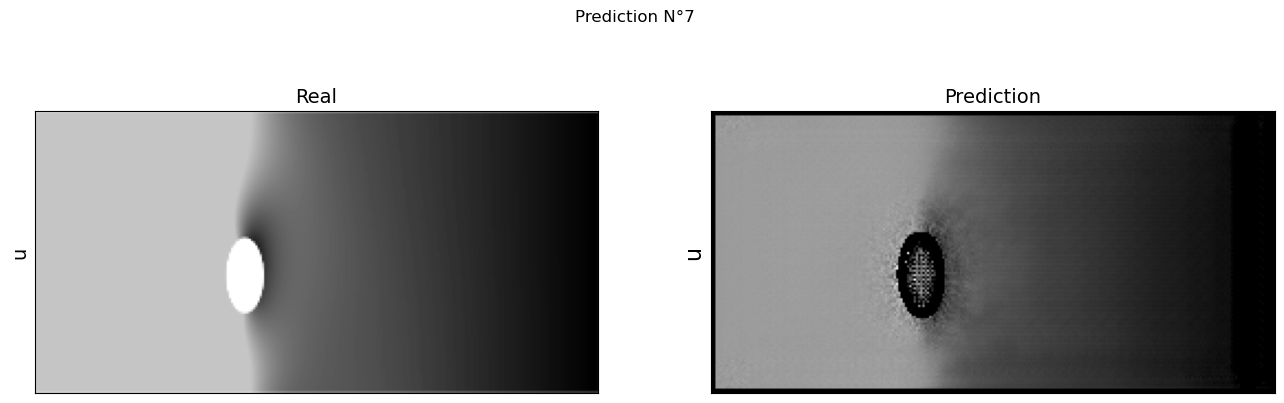

In [66]:

NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

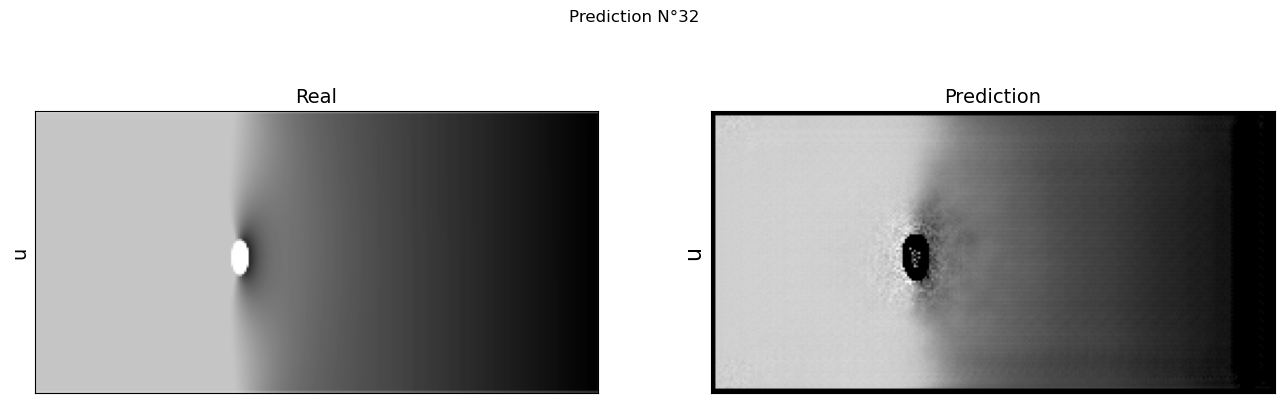

In [67]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

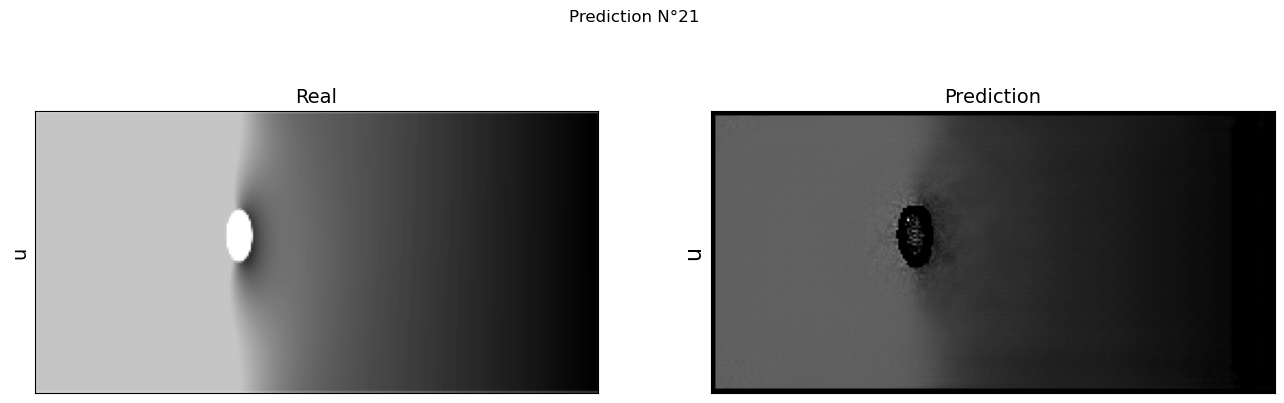

In [68]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

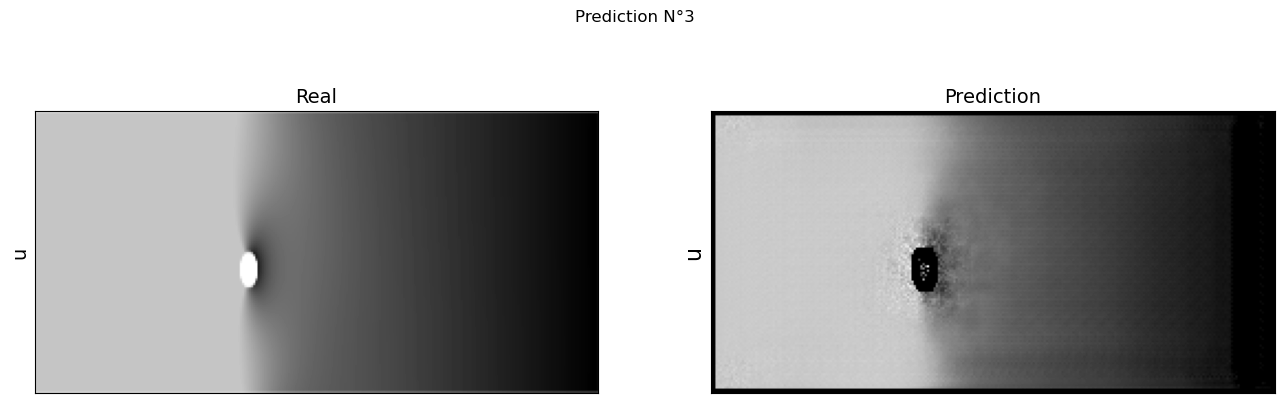

In [69]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

In [ ]:
'''
def MAEplus(u_true, u_pred):
     
  Eps=1e-4
  tensor_shape= tf.shape(u_true)
  mask= tf.ones(tensor_shape, dtype=u_true.dtype)
  index = tf.where(u_true == 1)
  scalar_value = 0
  values = tf.fill([tf.shape(index)[0]], scalar_value)
  values = tf.cast(values, mask.dtype)
  mask=tf.tensor_scatter_nd_update(mask, index, values)

  u_true_masked = tf.multiply(u_true, mask) 
  u_pred_masked = tf.multiply(u_pred, mask)
    
  Ip=tf.boolean_mask(u_pred, mask)
  shape_tensor=tf.shape(Ip)
  Ip_value = tf.get_static_value(shape_tensor)[0] 

  E_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_true_masked - u_pred_masked)))  
  E_normL1 = tf.abs(u_true_masked  - u_pred_masked)
  u_pred_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_pred_masked))) 
  mae_loss=E_normL1 + E_normL2/(u_pred_normL2 + Eps)
  mae_loss=mae_loss/Ip_value
  return mae_loss
''' 

[Attention U-Net - Video](https://www.youtube.com/watch?v=dirDQdHDi7I)

[U-Net vs Attention U-Net vs Attention Residual U-Net - Video ](https://www.youtube.com/watch?v=L5iV5BHkMzM)

[Attention U-net. What is attention and why is it needed for U-Net? - Video ](https://www.youtube.com/watch?v=KOF38xAvo8I)

[Attention U-Net: Learning Where to Look for the Pancreas - paper](https://arxiv.org/pdf/1804.03999)

[A U-net segmentation model for predicting free convection over confined isothermal tubes - paper](https://www.sciencedirect.com/science/article/abs/pii/S0735193324000332)

